# Lab 2: Neural Networks from Scratch

We will implement simple neural networks in Python using only `numpy` library (and `matplotlib` for visualization). The idea is to get a strong intuition of how it works. We will visualize the data space and the learning curve, and we will animate these over the learning process and experiment with different parameters. You will need the following libraries:

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import animation, rc
from IPython.display import HTML
import pandas as pd    


import requests

exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)

npt_config = {'session_name': 'lab2-map545',    'session_owner': 'aymeric',}

npt_config['sender_name'] = input("Name:")  
send('started', 0)
# Use your name and session TO_UPDATE with Aymeric DIEULEVEUT
# Use your name and session TO_UPDATE with Erwan SCORNET

Name:Erwan


<Response [200]>

## Table of contents


[1. The data](#data)<br>

[2. Very simple models](#Very_simple_models)<br>
- [2.1 A very simple Neural Network](#Very_simple_nn)<br>
- [2.2 Perceptron](#Perceptron)<br>
- [2.3 Logistic regression](#Logistic_regression)<br>
- [2.4 Another data set](#Another_data_set)<br>

[3. A more complex neural network](#More_complicated_nn)<br>

[4. Bonus](#Bonus)<br>






<a id='data'></a>

## 1 - The data

First, we create a toy problem to work with. Write a function to generate synthetic 2D 2-class data (i.e., $\mathbf{x} \in \mathbb{R}^2$ and $y \in \{-1,1\}$) such that: 
- $500$ observations are labelled $-1$ and $500$ observations are labelled $1$
- The observations from the class $-1$ are distributed as $\mathcal{N}(\mu_{-1}, \Sigma_{-1})$
- The observations from the class $1$ are distributed as $\mathcal{N}(\mu_{1}, \Sigma_{1})$

where $\mu_{-1} = (0,0)$, $\mu_1 = (2,2)$ and $
\Sigma_{-1} = \Sigma_{1} = \begin{pmatrix}
1 & 0 \\
0 & 1 \\
\end{pmatrix}.
$

**Using the following code, generate this data set and plot the result (e.g., an $x_1$ by $x_2$ scatter plot, where each class is coded by a different color).**

<Response [200]>

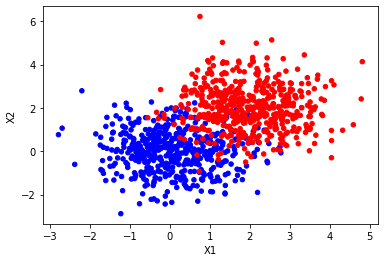

In [2]:
mu0 = [0,0]
mu1 = [2,2]
Sigma0 = np.array([[1,0],[0,1]])
Sigma1 = np.array([[1,0],[0,1]])
np.random.seed(4)

def create_dataset(nb_datapoints =1000, prop_class=0.5, Sigma0=Sigma0, Sigma1 = Sigma1, mu0 = mu0, mu1 = mu1):

    data_size = int(np.floor(nb_datapoints*prop_class))
    
    X0 = np.random.multivariate_normal(mean=mu0, cov = Sigma0, size = data_size)
    X1 = np.random.multivariate_normal(mean=mu1, cov = Sigma1, size = nb_datapoints-data_size)

    #plt.scatter(X0[:,0], X0[:,1], c = 'red')
    #plt.scatter(X1[:,0], X1[:,1], c = 'blue')

    dataset0 = np.concatenate((X0, np.repeat(-1,data_size).reshape(data_size,1)), axis=1)
    dataset1 = np.concatenate((X1, np.repeat(1,nb_datapoints-data_size).reshape(nb_datapoints-data_size,1)), axis=1)
    dataset = np.concatenate((dataset0, dataset1), axis=0)
    
    df = pd.DataFrame(dataset, columns = ["X1", "X2", "Y"])     
    #df = df.sample(frac=1)    
    return df;


#Create a data set and plot it

df = create_dataset()
colors = np.where(df["Y"]==1,'red','blue')
df.plot.scatter("X1", "X2", c = colors)


send(plt,1)

<a id='Very_simple_models'></a>


## 2 - Very simple models

<a id='Very_simple_nn'></a>

### 2.1 - A very simple neural network

#### 2.1.1 - Model definition

We will next implement a neural network with no hidden layer, with the sigmoid function as output function. We will consider the negative log-likelihood as the loss function and will solve the optimization problem with stochastic gradient descent (SGD). Recall that the sigmoid function $\sigma$ is defined as 

$$
\sigma(t) = \frac{1}{1+e^{-t}}.
$$

Let $\mathbf{w}, b$ be respectively the weights and the bias of the output layer. Recall that the probability output by the neural network is given by 

$$
\hat{\mathbb{P}}[Y=1 |\mathbf{X} = \mathbf{x}] = \sigma(\mathbf{w}^\top\mathbf{x}+b).
$$

##### Remark
We also have
$$
\hat{\mathbb{P}}[Y=-1 |\mathbf{X} = \mathbf{x}] = 1 - \sigma(\mathbf{w}^\top\mathbf{x}+b) = \sigma(- (\mathbf{w}^\top\mathbf{x}+b)).
$$
Consequently, for all $y \in \{-1,1\}$, we have
$$
\hat{\mathbb{P}}[Y=y |\mathbf{X} = \mathbf{x}] = \sigma(y (\mathbf{w}^\top\mathbf{x}+b)).
$$

##### Notations 
A simpler way to write this equation is to change slightly the input and the weight vector, in order to take into account the bias $b$. You can do so by adding a component equal to $1$ at the end of $\mathbf{x}$ that is considering 
$$
\tilde{\mathbf{x}} = (\mathbf{x}, 1),
$$
and similarly, with the weight vector
$$
\tilde{\mathbf{w}} = (\mathbf{w}, b).
$$
Notice that, in this case, we have
$$
\mathbf{w}^\top\mathbf{x}+b = \tilde{\mathbf{w}}^\top \tilde{\mathbf{x}}
$$
In this way, the output of the neural network can be written as 
$$
\hat{\mathbb{P}}[Y=1 |\tilde{\mathbf{X}} = \tilde{\mathbf{x}}] = \sigma(\tilde{\mathbf{w}}^\top \tilde{\mathbf{x}}).
$$
Note that you can add a column of ones at the end of the matrix $\textbf{X}$, to obtain the matrix $\tilde{\textbf{X}}$, instead of adding a component $1$ to each input vector $\textbf{X}_i$. 


**1) Prove that the negative log likelihood of the model is defined as
$$
\ell(\tilde{\mathbf{w}}, \mathcal{D}_n) = \frac{1}{n} \sum_{i=1}^n \log (1 + \exp(- y_i (\tilde{\mathbf{w}}^\top\tilde{\mathbf{x}}_i) ))
$$
and that its gradient is given by 
$$
\nabla \ell(\tilde{\mathbf{w}}, \mathcal{D}_n) = - \frac{1}{n} \sum_{i=1}^n \alpha_i \tilde{\mathbf{x}}_i,
$$**
where $\alpha_i \in \mathbb{R}$ satisfies
$$
\alpha_i = \frac{y_i }{1 + \exp( y_i (\tilde{\mathbf{w}}^\top \tilde{\mathbf{x}}_i) )}.
$$

**2) Using Python, write the corresponding functions: the negative log-likelihood, the gradient of the negative log-likelihood, the percentage of incorrect classification, i.e. $1 - accuracy$. These functions take as input the weight vector $\tilde{\mathbf{w}} = (\mathbf{w}, b)$ and the data set (which is a matrix of size $n \times (d+1)$, where $d=2$).**

In [3]:
def negative_log_likelihood_logistic(weights, dataset):
    y = dataset.iloc[:,-1]
    X = dataset.drop(df.columns[-1], axis = 1)
    Xtilde = np.concatenate((X, np.ones((X.shape[0],1))), axis=1)
    wtilde = weights
    ###### TO DO
    temp = y * (np.dot(Xtilde, wtilde))
    return np.mean(np.log(1+ np.exp(-temp)))
    ###### END TO DO 

send(negative_log_likelihood_logistic,2)    


def gradient_NLL_logistic(weights, dataset):
    y = dataset.iloc[:,-1]
    X = dataset.drop(df.columns[-1], axis = 1)
    Xtilde = np.concatenate((X, np.ones((X.shape[0],1))), axis=1)
    wtilde = weights
    
    ####### TO DO 
    #The following line computes is a division of one vector by another vector. In python, this computes 
    #the term-by-term division between the two vectors
    alpha = y/(1 + np.exp(y * (np.dot(Xtilde, wtilde))))
    
    #Inthe following line, the gradient is computed using the formula given in the question. Note that the 
    #calculation is done using matrices and vectors (Xtilde and alpha) but corresponds exactly to the formula
    #given in the question
    return -(1/dataset.shape[0])*(np.dot(np.matrix.transpose(Xtilde),alpha))
    ####### END TO DO 

send(gradient_NLL_logistic,3)    


def error(weights, dataset):
    y = dataset.iloc[:,-1]
    X = dataset.drop(df.columns[-1], axis = 1)
    Xtilde = np.concatenate((X, np.ones((X.shape[0],1))), axis=1)
    wtilde = weights
    ####### TO DO 
    return np.mean(y*(np.dot(Xtilde, wtilde))<0)
    ####### END TO DO 


send(error, 4)

test_weights =  [ 0.20825531, -1.68674417, -0.79965375]
send(negative_log_likelihood_logistic(test_weights, df), 5) 
send(gradient_NLL_logistic(test_weights, df), 6)
send(error(test_weights, df), 7)

print("The negative log-likelihood (NLL) at test_weights is", np.array(negative_log_likelihood_logistic(test_weights, df))) 
print("The gradient of the negative log-likelihood (NLL) at test_weights is", gradient_NLL_logistic(test_weights, df))
print("The percentage of error made by the previous estimator (for test_weights) is", np.array(error(test_weights, df)))

The negative log-likelihood (NLL) at test_weights is 2.2474496233386754
The gradient of the negative log-likelihood (NLL) at test_weights is [-0.88394035 -1.11178365 -0.28662361]
The percentage of error made by the previous estimator (for test_weights) is 0.643


#### 2.1.2 - Optimization and Visualization

**3) Now implement gradient descent using a loop (over iterations) to minimize the negative log likelihood using a  learning rate $\eta = 0.05$. Stop the gradient descent after $500$ steps. For each iteration, store the weights and the corresponding loss. Plot the corresponding loss as a function of the iteration.**

<Response [200]>

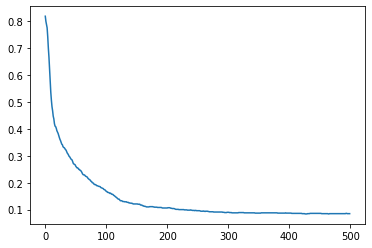

In [4]:
#Initializing parameters
eta = 0.05
count = 0

#Initializing weights
weights_logistic = np.random.normal(0, 1, size = 3)
# You can store the sequence of weights of the logistic model in this list, each entry is a set of 3 weights
list_weights_logistic = list()
# You can store the sequence of percentage of incorrect classification in this list, each entry is a percentage
list_error_logistic = list()
# You can store the sequence of negative log likelihood (NLL) in this list, each entry is a value of the NLL
list_likelihood_logistic = list()

while count<500: 
    ######## TO DO 
    list_weights_logistic.append(weights_logistic)
    list_likelihood_logistic.append(negative_log_likelihood_logistic(weights_logistic, df))
    list_error_logistic.append(error(weights_logistic, df))
    weights_logistic = weights_logistic - eta*gradient_NLL_logistic(weights_logistic, df)
    count = count +1
    ######## END TO DO 

plt.plot(list_error_logistic)

send(plt, 8)

**4) For the last iteration, plot the decision boundary and the observations. You just have to run the cell below.**

The loss is equal to 0.085


<Response [200]>

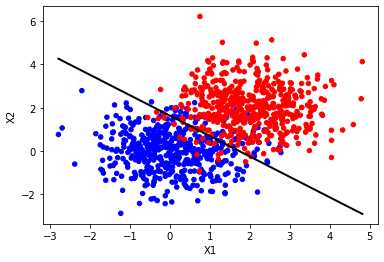

In [5]:
def boundary_equation(weights, dataset):
    X1min, X1max = (min(dataset["X1"]), max(dataset["X1"]))
    X2min, X2max = (min(dataset["X2"]), max(dataset["X2"]))
    if weights[1]!=0:
        x = np.array([X1min, X1max])
        z = (- weights[2] - weights[0]*x)/weights[1]        
    else:
        x = np.array([- weights[2]/weights[0],- weights[2]/weights[0] ])
        z = np.array([X2min, X2max])
        print(z)
    return x,z
        
#Plot the data and the boundary decision

def plot_data_and_boundary(weights, dataset):
    colors = np.where(df["Y"]==1,'red','blue')
    df.plot.scatter("X1", "X2", c = colors)
    return plt.plot(boundary_equation(weights, dataset)[0], boundary_equation(weights,dataset)[1], 'k-', lw=2)


plot_data_and_boundary(weights_logistic, df)
print("The loss is equal to", error(weights_logistic, df))
send(plt, 9)
send(np.array(error(weights_logistic, df)),10)

#### 2.1.3 - Animation

Move the implementation into a function called `animate(t)` where `t` is the epoch. In this function you should also update the plotting code using `set_data` and `contourf` (or `pcolormesh`) where appropriate. You may find [several examples/tutorials](https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/) on how to do this, if you are not familiar with these functions. Also, include a function called `init()` where you set up the plot. 

**5) Produce a mp4 video using the following code.**

In [6]:
from matplotlib import animation
from matplotlib import lines

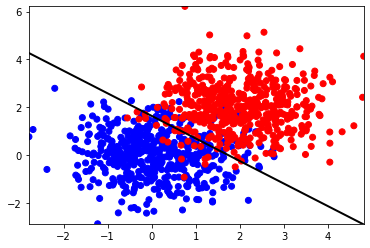

In [7]:
def create_animation(list_weights, dataset, filename):

    X1min, X1max = (min(dataset["X1"]), max(dataset["X1"]))
    X2min, X2max = (min(dataset["X2"]), max(dataset["X2"]))
    colors = np.where(df["Y"]==1,'red','blue')
    j=0

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    ax = plt.axes(xlim=(X1min, X1max), ylim=(X2min, X2max))
    #ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
    scat = plt.scatter(df["X1"], df["X2"], c = colors)
    line, = ax.plot([], [], 'k-', lw=2)



    # initialization function: plot the background of each frame
    def init():
        #scat = df.plot.scatter("X1", "X2", c = colors)
        line.set_data([], [])
        #ax.set_title("")
        return line,

    # animation function.  This is called sequentially
    def animate(i):
        #ax.set_title("iterations")
        #Use the command line.set_data(x_1, x_2) to plot a line passing by x_1 and x_2
        line.set_data(boundary_equation(list_weights[i], dataset)[0], boundary_equation(list_weights[i], dataset)[1]) 
        return line,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(list_weights), interval=50, blit=True)

    # save the animation as an mp4.  This requires ffmpeg or mencoder to be
    # installed.  The extra_args ensure that the x264 codec is used, so that
    # the video can be embedded in html5.  You may need to adjust this for
    # your system: for more information, see
    # http://matplotlib.sourceforge.net/api/animation_api.html
    final_filename = filename + ".mp4"
    anim.save(final_filename , fps=2, extra_args=['-vcodec', 'libx264'])

    plt.show()
    return

create_animation(list_weights_logistic,df, "nn_nohiddenlayer_nonlinearly_separable_dataset")

<a id='Perceptron'></a>


### 2.2 - Perceptron algorithm

**6) Implement the perceptron algorithm as seen in class. Start with the weights $(1,1,-8)$. Stop after $50000$ iterations. As for the neural network, produce a .mp4 video showing the evolution of the decision boundary.**

<Response [200]>

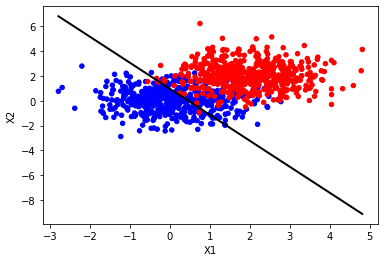

In [8]:
weights_perceptron = [1,1,-8]
y = df.iloc[:,-1]
X = df.drop(df.columns[-1], axis = 1)
Xtilde = np.concatenate((X, np.ones((X.shape[0],1))), axis=1)


# You can store the sequence of weights of the perceptron in this list, each entry is a set of 3 weights
list_weights_perceptron = list()
#Initialisation for this list
list_weights_perceptron.append(weights_perceptron)

# You can store the sequence of percentage of incorrect classification in this list, each entry is a percentage
list_error_perceptron = list()
list_error_perceptron.append(error(weights_perceptron, df))

#Remembering the iteration number 
iteration = 0 
list_iteration = list()

#Number of updates: number of times were weights are actually updated
nb_update = 0

while iteration < df.shape[0]*50: 
    ###### TO DO 
    i = iteration%df.shape[0]
    if y[i]*(np.dot(Xtilde[i,:], weights_perceptron))<0:
        weights_perceptron = weights_perceptron + y[i] * Xtilde[i,:]
        list_weights_perceptron.append(weights_perceptron)
        list_error_perceptron.append(error(weights_perceptron, df))
        nb_update += 1
        list_iteration.append(iteration+1)
    iteration += 1
    ###### END TO DO 
    
plot_data_and_boundary(list_weights_perceptron[14], df)
send(plt, 11)

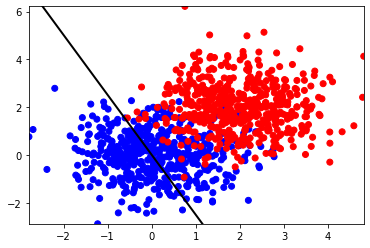

In [9]:
create_animation(list_weights_perceptron ,df, "perceptron_nonlinearly_separable_dataset")

<a id='Logistic_regression'></a>


### 2.3 - Logistic regression

**7) Using the package scikit-learn, compute the weights given by the logistic regression. Plot the decision boundary and the observations.**

<Response [200]>

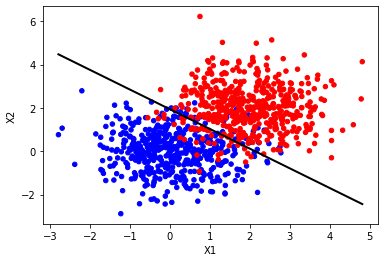

In [10]:
from sklearn.linear_model import LogisticRegression
dataset = df
y = df.iloc[:,-1]
X = dataset.drop(df.columns[-1], axis = 1)

##### TO DO 
clf = LogisticRegression(solver='lbfgs').fit(X, y)
# or clf = LogisticRegression(random_state = 0, solver = 'lbfgs').fit(X,y)
weights_logistic_scikit = np.append(clf.coef_[0], clf.intercept_)
##### END TO DO 

#Plot the data and the boundary decision
plot_data_and_boundary(weights_logistic_scikit, df)


send(weights_logistic_scikit, 12)

In [11]:
weights_logistic_scikit

array([ 1.98379786,  2.18256941, -4.22467763])

<a id='Another_data_set'></a>

### 2.4 - Linearly separable data set

**8) Use the function 'create_dataset' defined in the second cell to generate a linearly separable data set and run again the neural network, the perceptron implemented above (with mp4 videos) and the logistic regression.** 

<Response [200]>

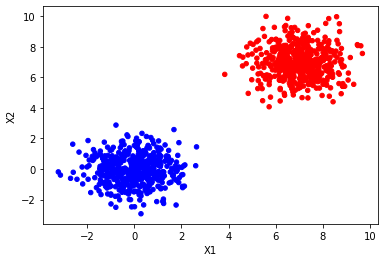

In [12]:
# Defining new means and covariance matrices
mu0 = [0,0]
mu1 = [7,7]
Sigma0 = np.array([[1,0],[0,1]])
Sigma1 = np.array([[1,0],[0,1]])

#Create a data set and plot it
df = create_dataset(nb_datapoints =1000, prop_class=0.5, Sigma0=Sigma0, Sigma1 = Sigma1, mu0 = mu0, mu1 = mu1)
colors = np.where(df["Y"]==1,'red','blue')
df.plot.scatter("X1", "X2", c = colors)

send(plt, 13)

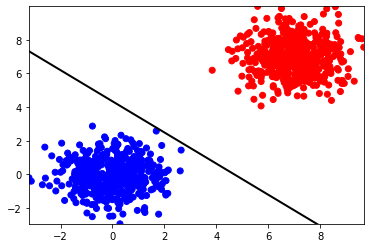

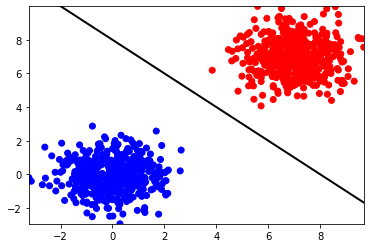

<Response [200]>

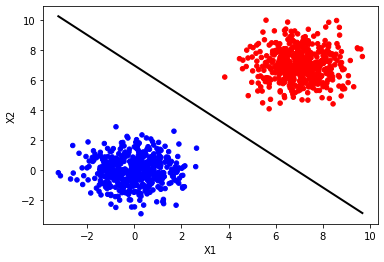

In [13]:
# 1 - Neural Network 

###### TO DO 

#Initializing parameters
eta = 0.05
count = 0

#Initializing parameters
eta = 0.05
count = 0

#Initializing weights
weights_logistic = np.random.normal(0, 1, size = 3)
# You can store the sequence of weights of the logistic model in this list, each entry is a set of 3 weights
list_weights_logistic = list()
# You can store the sequence of percentage of incorrect classification in this list, each entry is a percentage
list_error_logistic = list()
# You can store the sequence of negative log likelihood (NLL) in this list, each entry is a value of the NLL
list_likelihood_logistic = list()

while count<500: 
    list_weights_logistic.append(weights_logistic)
    list_likelihood_logistic.append(negative_log_likelihood_logistic(weights_logistic, df))
    list_error_logistic.append(error(weights_logistic, df))
    weights_logistic = weights_logistic - eta*gradient_NLL_logistic(weights_logistic, df)
    count = count +1

######## END TO DO 

#####################

# 2 - Perceptron

#####################

# TO DO 

weights_perceptron = [1,1,-8]
y = df.iloc[:,-1]
X = df.drop(df.columns[-1], axis = 1)
Xtilde = np.concatenate((X, np.ones((X.shape[0],1))), axis=1)

# You can store the sequence of weights of the perceptron in this list, each entry is a set of 3 weights
list_weights_perceptron = list()
#Initialisation for this list
list_weights_perceptron.append(weights_perceptron)

# You can store the sequence of percentage of incorrect classification in this list, each entry is a percentage
list_error_perceptron = list()
list_error_perceptron.append(error(weights_perceptron, df))

#Remembering the iteration number 
iteration = 0 
list_iteration = list()

#Number of updates: number of times were weights are actually updated
nb_update = 0

while iteration < df.shape[0]*50: 
    i = iteration%df.shape[0]
    if y[i]*(np.dot(Xtilde[i,:], weights_perceptron))<0:
        weights_perceptron = weights_perceptron + y[i] * Xtilde[i,:]
        list_weights_perceptron.append(weights_perceptron)
        list_error_perceptron.append(error(weights_perceptron, df))
        nb_update += 1
        list_iteration.append(iteration+1)
    iteration += 1

# END TO DO 
#####################

create_animation(list_weights_logistic ,df, "nn_nohiddenlayer_linearly_separable_dataset")
create_animation(list_weights_perceptron ,df, "perceptron_linearly_separable_dataset")

# 3 - Logistic regression

#####################
# TO DO 

from sklearn.linear_model import LogisticRegression
dataset = df
y = df.iloc[:,-1]
X = dataset.drop(df.columns[-1], axis = 1)
clf = LogisticRegression(solver='lbfgs').fit(X, y)
weights_logistic_scikit = np.concatenate((clf.coef_ , np.array(clf.intercept_).reshape(1,1)), axis = 1).reshape(3,)

#Plot the data and the boundary decision
plot_data_and_boundary(weights_logistic_scikit, df)

# END TO DO 
#####################


send(np.array(list_error_logistic), 14)
send(np.array(list_error_perceptron), 15)
send(np.array(nb_update), 16)

**9) What are the main similarities/differences between the three algorithms?**

**Answer.** The only difference between the neural network with no hidden layer and the logistic regression is the optimization procedure (Stochastic gradient descent for the neural network, L-BGFS i.e. Limited memory Broyden–Fletcher–Goldfarb–Shanno a second-order optimization algorithm). The statistical model is the same. There is no statistical model behind the perceptron algorithm and the optimization algorithm can be seen as a stochastic gradient descent. 

The perceptron algorithm converges only when the data are linearly separable. When it is the case, it converges faster than the implemented neural network. This is notably due to the step size $\eta$ which is larger for the perceptron. Note also that the weights do not necessarily converge for logistic regression for linearly separable dataset: there exists an infinite number of hyperplane that well separate the data (up to a normalizing constant). 

When the data set is not linearly separable, the perceptron fails to converge. 

**10) Since Gaussian data were generated, could we determine the best decision boundary? Do you know another algorithm,  particularly useful in this case to approximate the best decision boundary.** 

**Answer.** When data are Gaussian, the expression of the best decision function can be determined analytically. The linear discriminant analysis is a model/package that approximate the true coefficient of the decision boundary by their empirical counterpart.  

<a id='More_complicated_nn'></a>
## 3 - A more complicated neural network



**Use the command below to create and plot a new data set.**

<Response [200]>

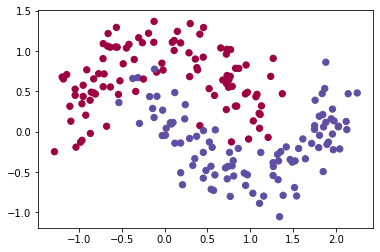

In [15]:
import sklearn
from sklearn import datasets

X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

send(plt, 17)

We want to build a network with one hidden layer. The number of neurons in this network will be a variable called nn_hdim.  Let us define the following variables. 

In [16]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
 
# Gradient descent parameters
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0 # regularization strength for a L2 penalization over the weights (but not over the bias)

A network is defined by its parameters. We will thus define a dictionnary to describe a network, this dictionnary being composed of four elements named 'W1','b1','W2','b2'. We use tangent as activation function, the softmax as output function and the negative log likelihood as the loss function. 



The equations defining the network are 

\begin{align*}
z_1 & = x W_1 + b1\\
a_1 & = \tanh(z_1) \\
z_2 & = a_1 W_2 + b_2 \\
a_2 & = \hat{y} = \textrm{softmax}(z_2) 
\end{align*}

where $z_1, x, b_1, a_1, b_2, z_2, a_2$ are arrays (and not vectors!). Letting $ \hat{y}$ be the $(1,2)$ array containing the predicted probabilities for each class as above, and $y_{\textrm{hot encoding}}$ being the one-hot encoding of $y$ (the vector containing zeros except in the $y$ position that contains $1$), the negative log loss is given by 
\begin{align*}
\ell(y,\hat{y}) & = - y \log(\hat{y}_1) - (1- y) \log(\hat{y}_0)\\
& = - y_{\textrm{hot encoding}} \odot \log(\hat{y}).
\end{align*}

**11) Now, create two functions, the first one `calculate_loss(model, X, y)` to compute the loss of a model on the entire data set (composed of the input matrix X and the output vector y) and the second one `predict(model,x)` to predict the output of a model for a new observation `x`.**

In [17]:

def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    ######### TO DO - remove the right-hand side of all equations until next END TO DO - keep the comments
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    correct_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(correct_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    ######### END TO DO
    return 1./num_examples * data_loss

send(calculate_loss, 18)



# Helper function to predict an output (0 or 1)

#####################
# TO DO
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    ######### TO DO - remove the right-hand side of all equations until next END TO DO 
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    ##### END TO DO 
    return np.argmax(probs, axis=1)

send(predict, 19)

<Response [200]>

**12) Derive the calculations that are necessary to update the weights.**

By definition, 
\begin{align*}
\ell(y,\hat{y}) & = - \sum_{j=1}^2 y_i \log(\hat{y}_i) \\
& = - \sum_{j=1}^2 y_i (z_2)_j + \log(\sum_{j=1}^2 e^{(z_2)_j}).
\end{align*}
Consequently, 
\begin{align*}
\frac{\partial \ell }{\partial (z_2)_j} = \hat{y}_j - y_j,
\end{align*}
and
\begin{align*}
\frac{\partial \ell }{\partial z_2} = \hat{y} - y, \quad \frac{\partial \ell }{\partial b_2} = \hat{y} - y.
\end{align*}
Finally, 
\begin{align*}
\frac{\partial \ell }{\partial (W_2)_{ik}} & = \sum_j \frac{\partial \ell }{\partial (z_2)_j} \frac{\partial (z_2)_j}{\partial (W_2)_{ik}}\\
& = (\hat{y}_k - y_k) (a_1)_i, 
\end{align*}
that is 
\begin{align*}
\frac{\partial \ell }{\partial W_2} & = a_1^T (\hat{y} - y). 
\end{align*}
Recalling that $\tanh ' = 1 - \tanh^2$, the same derivations lead to 
\begin{align*}
\frac{\partial \ell }{\partial b_1} = (1 - \tanh^2(z_1)) \circ (\hat{y} - y) W_2^T , \quad \textrm{and} \quad \frac{\partial \ell }{\partial W_1} & = x^T ((1 - \tanh^2(z_1)) \circ (\hat{y} - y) W_2^T). 
\end{align*}

**13) Write a function `build_model(nn_hdim, num_passes=20000, print_loss=False)` to build the network.** 

In [18]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

#####################
# TO DO

def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
 
    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):
 
        ####### TO DO - remove all right-hand side of equations - keep comments
        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        ##### END TO DO 
        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        
        ####### TO DO - remove all right-hand side of equations - keep comments
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
 
        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
 
        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        ##### END TO DO 
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        #if print_loss and i % 1000 == 0:
            #  print &quot;Loss after iteration %i: %f&quot; %(i, calculate_loss(model))
    
    return model



**14) Test the network performance with different numbers of neurons in the hidden layer. Plot the decision function. You can use the function below.**

In [19]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

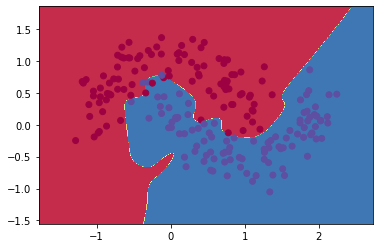

In [20]:
model = build_model(10, print_loss=True)
 
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
#plt.title(&quot;Decision Boundary for hidden layer size 3&quot;)

<a id='Bonus'></a>

## 4 -  Bonus: Experiments

You can try to improve the network performance by adding the following mechanisms: 
- Different learning rates; try decaying the learning rate
- Different initialization of $\mathbf{w}$
- Activation function (e.g., try a rectified linear units)
- Plot the error rate also on some test data from the same distribution (generate some more)
- Calculate the gradient on a batch of 10 instances at a time (instead of just one)